# Sky Backgound Subtraction and Aperture Photometry

The first step is loading one scientific frame and the corresponding estimates of the associated error.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pickle
from astropy.io import fits
%matplotlib widget

science_list = np.genfromtxt('./group10_WASP-135_20190803/science/science.list', dtype=str)
science_temp_list = science_list[:30]
science_corrected = pickle.load(open('./group10_WASP-135_20190803/correct/' + science_temp_list[0][:-5] + '_corr.p', 'rb'))
science_corrected_err = pickle.load(open('./group10_WASP-135_20190803/correct/' + science_temp_list[0][:-5] + '_corr_error.p', 'rb'))

We now report here the coordinates of the target measured in the previous step of our analysis (see 04 - Centroid Measurement). We also prepare the meshgrid and the distance from the centre of our target

In [2]:
# Refined  coordinates of the target
x_target_refined = 228.66
y_target_refined = 32.85

# Computing again the meshgrid arrays 
ylen, xlen = np.shape(science_corrected)
X_axis = np.arange(0, xlen, 1)
Y_axis = np.arange(0, ylen, 1)
X, Y = np.meshgrid(X_axis, Y_axis)

# 2D array with the distance of each pixel from the target star 
target_distance = np.sqrt((X-x_target_refined)**2 + (Y-y_target_refined)**2)


Now we define a function to draw a circle like we did in the previous step.

In [3]:
def make_circle_around_star(x_pos, y_pos, radius, thickness=0.5, label='', color='w', alpha=1.):

    n, radii = 50, [radius, radius+thickness]
    theta = np.linspace(0, 2*np.pi, n, endpoint=True)
    xs = np.outer(radii, np.cos(theta))
    ys = np.outer(radii, np.sin(theta))
    
    # in order to have a closed area, the circles
    # should be traversed in opposite directions
    xs[1,:] = xs[1,::-1]
    ys[1,:] = ys[1,::-1]
    
    ax.fill(np.ravel(xs)+x_pos, np.ravel(ys)+y_pos, edgecolor=None, facecolor=color, alpha=alpha, label=label)

### Computation of the sky background

We want to compute the average sky background around our star and so we need a region without starts or other contaminants. We could select any region of the frame but we don't know if the background level is constant. So we will select a ring (*annulus*) around our target, centered in the centroid. Our task is to define inner and outer radius.

**Inner Radius** must be large enough to include our star completely and some background as well. We can still use the radius that we used for the centroid measurement or a little larger.

**Outer Radius** the outer radius has to be larger but it must not include any other source.

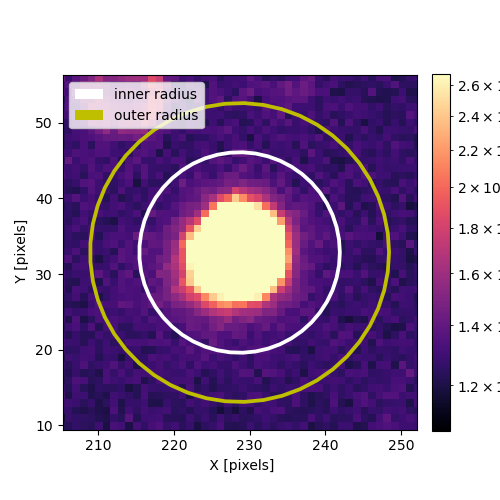

In [4]:
# Value for the radii
inner_radius = 13
outer_radius = 19.5
from matplotlib import colors

vmin = np.amin(science_corrected[:,100:400])
vmax = np.amax(science_corrected[:,100:400])

vmax = 2.5*vmin

fig, ax = plt.subplots(1, figsize=(5,5))
im1 = plt.imshow(science_corrected, cmap=plt.colormaps['magma'], norm=colors.LogNorm(vmin=vmin, vmax=vmax), origin='lower')
plt.colorbar(im1,ax=ax, fraction=0.046, pad=0.04)

# Cut the plot around the target star, with some margin with respect to the inner radius
plt.xlim(x_target_refined-outer_radius*1.2, x_target_refined+outer_radius*1.2)
plt.ylim(y_target_refined-outer_radius*1.2, y_target_refined+outer_radius*1.2)

make_circle_around_star(x_target_refined, y_target_refined, inner_radius, label='inner radius')
make_circle_around_star(x_target_refined, y_target_refined, outer_radius, color='y', label='outer radius')

plt.xlabel(' X [pixels]')
plt.ylabel(' Y [pixels]')
plt.legend(loc='upper left')
plt.show()

To compute the sky background, we select the pixels within the two radii. We have to make sure that we have more than 150 pixels to compute the mean and median over a statistically significant sample size of pixels.

In [5]:
target_distance = np.sqrt((X-x_target_refined)**2 + (Y-y_target_refined)**2)

# Select region between the two radii and create 2D boolean matrix.
annulus_selection = (target_distance > inner_radius) & (target_distance < outer_radius)

# Compute median and average
sky_flux_average = np.sum(science_corrected[annulus_selection]) / np.sum(annulus_selection)
sky_flux_median = np.median(science_corrected[annulus_selection])

print('Number of pixels included in the annulus: {0:7.0f}'.format(np.sum(annulus_selection)))
print('Average Sky flux: {0:7.1f} photons/pixel'.format(sky_flux_average)) 
print('Median Sky flux: {0:7.1f} photons/pixel'.format(sky_flux_median)) 

sky_flux_average_error = np.std(science_corrected[annulus_selection])/np.sqrt(len(science_corrected[annulus_selection]))
sky_flux_median_error = sky_flux_average_error * 1.253

print('Error on the average: {0:.3f} photons/pixel'.format(sky_flux_average_error))
print('Error on the median: {0:.3f} photons/pixel'.format(sky_flux_median_error))

# Sono consistenti

Number of pixels included in the annulus:     665
Average Sky flux:  1288.8 photons/pixel
Median Sky flux:  1287.9 photons/pixel
Error on the average: 1.607 photons/pixel
Error on the median: 2.014 photons/pixel


When computing the sky background, we consider two main metrics: the **mean** ($\text{sky\_flux\_average}$) and the **median** ($\text{sky\_flux\_median}$). However, while the **mean** has a well-defined analytical error formula, the **median** does not, and its error must be estimated.

The error on the **mean** is given by:

$$
\sigma_{\text{mean}} = \frac{\sigma_{\text{pixel}}}{\sqrt{N}}
$$

where $\sigma_{\text{pixel}}$ is the standard deviation of the pixels in the sky background annulus, and $N$ is the number of selected pixels.

There is no direct analytical formula for the **median** error, but it can be approximated as:

$$
\sigma_{\text{median}} \approx \frac{1.253 \cdot \sigma_{\text{pixel}}}{\sqrt{N}}
$$

where the factor $1.253$ accounts for the relationship between the median and the standard deviation in a normal distribution.

If the sky background distribution is **Gaussian**, the mean and median should be very similar, and their errors should be consistent. If **outliers** or **skewed distributions** are present, the median will be more robust than the mean, potentially leading to discrepancies.

The error on the mean is computed as $ \sigma_{\text{mean}} = \sigma / \sqrt{N} $, while the error on the median can be estimated using the factor $ 1.253 $. If the mean and median are not consistent within the computed errors, this may indicate the presence of outliers or spatial variations in the background.

If the sky background follows a **Gaussian distribution**, the mean is a good choice. If outliers or asymmetric variations are present, the median is more reliable.

### Removing the Sky Background from the Measured Flux
The error on the sky-subtracted flux is computed using error propagation for subtraction:

$$
\sigma_{\text{science\_sky\_corrected}} = \sqrt{\sigma_{\text{science}}^2 + \sigma_{\text{sky}}^2}
$$

where:
- $\sigma_{\text{science}}$ is the error on the science frame,
- $\sigma_{\text{sky}} = \frac{\sigma_{\text{pixel}}}{\sqrt{N}}$ is the error on the sky background estimate.

If the background is well-determined (large $N$), the total error is mostly influenced by $\sigma_{\text{science}}$. Otherwise, $\sigma_{\text{sky}}$ can significantly contribute.



In [6]:
science_sky_corrected = science_corrected - sky_flux_average
science_sky_corrected_error = np.sqrt(science_corrected_err**2 + sky_flux_average_error**2)

### Aperture Photometry
The basic principle is to sum the observed flux within a given region called *aperture*. We will employ a circular aperture, defined by centroid and radius (which is the aperture).
The choice of the aperture depends on the science case; since we want to measure the star's flux, we have to include the totality of the star.
We have to consider that pixels on the margin of the star will probably have a very low flux star (e.g. 100 photons) and a higher sky_background value (e.g. 2000 photons), so its error will approximately be of 50 photons. The marginal pixels will then contribute to the total measurement of about 100 +- 50 which is negligible.
Most of the time an aperture including 80-90% of the flux may provide the best results.

In the plot below we report the measured flux with different apertures, divided by the total flux within the largest meaningful aperture.

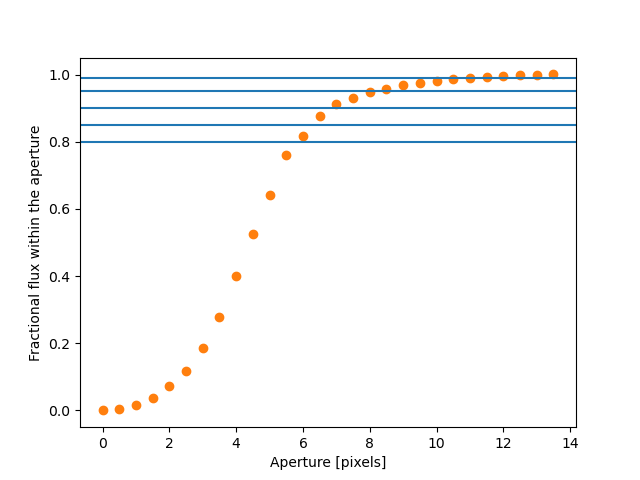

'We select the apertures corresponding to 0.80, 0.85, 0.90 and 0.95'

In [ ]:
# Cumulative distribution of flux as a function of radius
plt.figure()

inner_selection = (target_distance < inner_radius)
total_flux = np.sum(science_sky_corrected[inner_selection])

radius_array = np.arange(0, inner_radius + 1, 0.5)
flux_vs_radius = np.zeros_like(radius_array)

for i, aperture_radius in enumerate(radius_array):
    aperture_selection = (target_distance < aperture_radius)
    flux_vs_radius[i] = np.sum(science_sky_corrected[aperture_selection])/total_flux

plt.scatter(radius_array, flux_vs_radius, c='C1')
plt.axhline(0.80)
plt.axhline(0.85)
plt.axhline(0.90)
plt.axhline(0.95)
plt.axhline(0.99)

plt.xlabel('Aperture [pixels]')
plt.ylabel('Fractional flux within the aperture')
plt.show()




We select different apertures (6, 6.5, 7 and 7.5 pixels) and perform photometric analysis on all of them. Later on we will compare them and select the one with the smaller associated error.

The error associated with the absolute flux measurement within the aperture is computed considering the error propagation in the **sum** of the pixel values, without normalization.

If the total flux in the aperture is:

$$
F_{\text{aperture}} = \sum_{i=1}^{N} F_i
$$

where $F_i$ is the flux of each pixel within the aperture and $N$ is the number of selected pixels, the associated error is given by the **square root of the sum of the squared individual errors**:

$$
\sigma_{\text{aperture}} = \sqrt{\sum_{i=1}^{N} \sigma_i^2}
$$

where $\sigma_i$ is the error associated with each pixel flux.

If the errors vary among pixels, each individual error must be squared and summed before taking the square root.

This formula accounts for the fact that uncertainties in individual pixel values propagate into the total flux measurement, increasing the overall error.


### Comparing the star with a multivariate_normal
We want to check how much the PSF of the target is departing from a 2D Gaussian shape with a simple qualitative approach. We compare the photometry as a function of radius of two simulated stars with ours. To simulate the star we use multivariate normal provided by SciPy

In [ ]:
from scipy.stats import multivariate_normal

xy_range = np.arange(-inner_radius*1.2, inner_radius*1.2) # Set borders for the plot
X_gauss, Y_gauss = np.meshgrid(xy_range, xy_range) # Create a meshgrid for the selected region

pos = np.dstack((X_gauss, Y_gauss)) # Crea un array 3D a partire da 2 array 2D

gauss_distance = np.sqrt((X_gauss)**2 + (Y_gauss)**2)

plot_range = np.arange(0, inner_radius, 0.1) # Crea un array che va da 0 a inner_radius ogni 0.1

# Create two 2D normal distributions with three different values for the covariance:
#allow_singular=False mostra un errore se la matrice non è invertibile (non puoi estrarre la probabilità in quel caso)
mv_normal_cov05 = multivariate_normal(mean=[0., 0.], cov=5., allow_singular=False) 
mv_normal_cov05_pdf = mv_normal_cov05.pdf(pos) #restituisce la probability distribution function
plot_cov05_flux = np.zeros_like(plot_range)

mv_normal_cov10 = multivariate_normal(mean=[0., 0.], cov=10., allow_singular=False)
mv_normal_cov10_pdf = mv_normal_cov10.pdf(pos)
plot_cov10_flux = np.zeros_like(plot_range)

mv_normal_cov20 = multivariate_normal(mean=[0., 0.], cov=20., allow_singular=False)
mv_normal_cov20_pdf = mv_normal_cov20.pdf(pos)
plot_cov20_flux = np.zeros_like(plot_range)

for i, aperture_radius in enumerate(plot_range):
    pdf_selection = (gauss_distance < aperture_radius)
    plot_cov05_flux[i] = np.sum(mv_normal_cov05_pdf[pdf_selection])
    plot_cov10_flux[i] = np.sum(mv_normal_cov10_pdf[pdf_selection])
    plot_cov20_flux[i] = np.sum(mv_normal_cov20_pdf[pdf_selection])
